In [1]:
import torch
from torch import nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

# Check for GPU (should return True)
print(torch.cuda.is_available())

True


# 1. Data (preparing and loading)

In [2]:
# Create *known* parameters 
data_weight = 0.7
data_bias = 0.3

# Create range values
data_start = 0
data_end = 1
data_step = 0.02

# Create X and y (features and labels)
data_X = torch.arange(data_start, data_end, data_step).unsqueeze(dim=1)
data_y = data_weight * data_X + data_bias

In [3]:
data_X[:10]

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])

In [4]:
data_X.shape

torch.Size([50, 1])

In [5]:
data_y[:10]

tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])

In [6]:
data_y.shape

torch.Size([50, 1])

## Splitting data into training and test sets

* training set 60-80% of data (course materials) - always
* validation set 10-20% of data (practice exam) - sometimes
* test set 10-20% of data (final exam) - always

_Generalization_ - the ability for a machine learning model to perform well on data it hasn't seen before.

In [7]:
data_train_split = int(0.8 * len(data_X))
data_train_split

40

In [8]:
# Split data
data_X_train = data_X[:data_train_split]
data_y_train = data_y[:data_train_split]
data_X_test = data_X[data_train_split:]
data_y_test = data_y[data_train_split:]

In [9]:
len(data_X_train), len(data_y_train), len(data_X_test), len(data_y_test)

(40, 40, 10, 10)

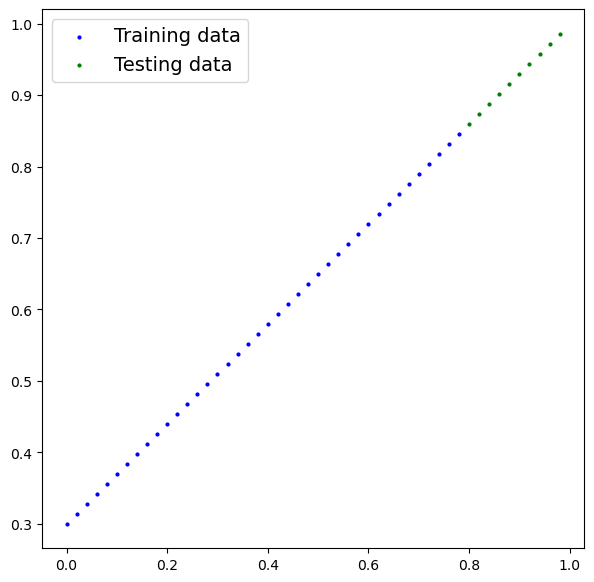

In [10]:
# Visualization function
def plot_predictions(train_data=data_X_train,
                     train_labels=data_y_train,
                     test_data=data_X_test,
                     test_labels=data_y_test,
                     predictions=None):
    """
    Plots training data, test data and compares predictions
    """
    # Canvas size
    plt.figure(figsize=(7, 7))

    # plt.scatter(x, y, c)
    # x, y - coordinates
    # c - color
    # s - dot size
    
    # Plot training data in blue
    plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')

    # Plot training data in green
    plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')

    # Are there predictions 
    if predictions is not None:
        # Plot the predictions if they exists
        plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

    # Show the legend
    plt.legend(prop={'size': 14})




plot_predictions()

# 2. Build model

In [11]:
# Create linear regression model class
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize model parameters
        self.weights = nn.Parameter(torch.randn(1, 
                                               requires_grad=True,
                                               dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))

        # Forward method to define the computation in the model
    def forward(self,
               x: torch.Tensor) -> torch.Tensor: # "x" is the input data
        return self.weights * x + self.bias # this is linear regression formula
            

<img src="../pycharm/images/1-1.png">

Gradient descent

* https://www.youtube.com/watch?v=IHZwWFHWa-w

Backpropogation

* https://www.youtube.com/watch?v=Ilg3gGewQ5U

<img src="../pycharm/images/1-2.png">

<img src="../pycharm/images/1-3.png">

## Checking the contents of PyTorch model

In [12]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()

In [13]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [14]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [15]:
data_weight, data_bias

(0.7, 0.3)

In [16]:
# The point is for the model to adjust the random values so that they are almost the same as the ideal values.
# weight: 0.3367 -> 0.7
# bias: 0.1288 -> 0.3

## Making predictions using `torch.inference_mode()`

In [17]:
# Make predictions with model
with torch.inference_mode():
    data_y_preds = model_0(data_X_test)

data_y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [18]:
data_y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

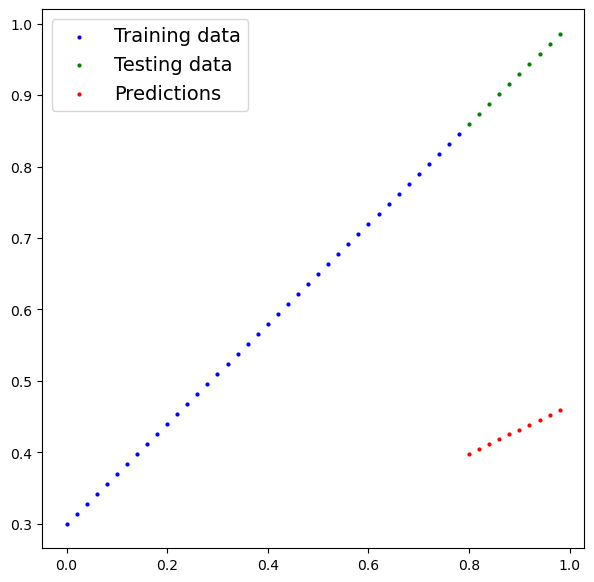

In [19]:
plot_predictions(predictions=data_y_preds)

# 3. Train model
The point is for the model to adjust the random values so that they are almost the same as the ideal values.

* weight: 0.3367 -> 0.7
* bias: 0.1288 -> 0.3

One way to measure how poor or how wrong models predictions are is to use a __loss function__.

__Loss function__ - a function to measure how wrong your model's predictions are to the ideal outputs (the lower the better)

Loss function may also be called "cost function" or "criterion" in different areas. 

__Optimizer__ - takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias) to improve the loss function

For PyTorch we need:
* A trainig loop
* A testing loop

In [20]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

<img src="../pycharm/images/1-4.png">

In [21]:
# Setup a loss function
data_loss_fn = nn.L1Loss()

# Setup an optimizer (SGD - stochastic gradient descent)
# hyperparameter - is a value that machine learning engineer set by hand
# lr - most important hyperparameter 
data_optimizer = torch.optim.SGD(params=model_0.parameters(),
                                lr=0.01)

## Building a trainig loop (and a testing loop) PyTorch

Loop through the data and do:
1. Forward pass (or forward propagation) - `forward()` - function, a walkthrough from the input layer to the output layer, making predictions
2. Calculate the loss - compare forward pass predictions to ground truth labels
3. Optimizer zero grad
4. Loss backward (or back propagation) - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss
5. Optimizer step (or gradient descent) - use the optimizer to adjust our model's parameters to try and improve the loss 

In [22]:
torch.manual_seed(42)

# An epoch is one loop through the data
# epoch is hyperparameter because we've set it ourselves
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

# Loop through the data
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

    # 1. Forward pass
    data_y_preds = model_0(data_X_train)

    # 2. Calculate the loss
    loss = data_loss_fn(data_y_preds, data_y_train)

    # 3. Optimizer zero grad
    data_optimizer.zero_grad()
    
    # 4. Perform back propagation on the loss with respect to the parameters of the model
    loss.backward()

    # 5. Optimizer step - perform gradient descent
    # by default how the optimizer changes will accumulate through the loop, so we have to zero them above in step 3 for the next iteration of the loop
    data_optimizer.step() 

    
    # Testing
    model_0.eval() # turns off different settings in the model not needed for evaluation/testing (dropout/batch norm lay layers)
    with torch.inference_mode(): # Turns off gradient tracking
        # 1. Do the forward pass
        data_test_pred = model_0(data_X_test)

        # 2. Calculate the loss
        test_loss = data_loss_fn(data_test_pred, data_y_test)
        
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        

<img src="../pycharm/images/1-5.png">

<img src="../pycharm/images/1-6.png"> 

# 4. Saving PyTorch model's state_dict()

In [23]:
# 1. Create models directory 
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = '01-workflow-model-0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
torch.save(obj=model_0.state_dict(),
          f=MODEL_SAVE_PATH)



# 5. Loading PyTorch model's state_dict()

In [24]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [25]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

# 6. Putting it all together

<img src="../pycharm/images/1-3.png">

In [26]:
import torch
from torch import nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 6.1 Data

In [27]:
# Create some data using the linear regression formula y = weight * X + bias
# Create *known* parameters 
data_weight = 0.7
data_bias = 0.3

# Create
data_start = 0
data_end = 1
data_step = 0.02

# Create X and y (features and labels)
data_X = torch.arange(data_start, data_end, data_step).unsqueeze(dim=1).to(device)
data_y = data_weight * data_X + data_bias

In [28]:
# Split data
data_train_split = int(0.8 * len(data_X))
data_X_train = data_X[:data_train_split]
data_y_train = data_y[:data_train_split]
data_X_test = data_X[data_train_split:]
data_y_test = data_y[data_train_split:]

In [29]:
# Visualization function
def plot_predictions(train_data=data_X_train,
                     train_labels=data_y_train,
                     test_data=data_X_test,
                     test_labels=data_y_test,
                     predictions=None):
    """
    Plots training data, test data and compares predictions
    """
    # Canvas size
    plt.figure(figsize=(7, 7))

    # plt.scatter(x, y, c)
    # x, y - coordinates
    # c - color
    # s - dot size
    
    # Plot training data in blue
    plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')

    # Plot training data in green
    plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')

    # Are there predictions 
    if predictions is not None:
        # Plot the predictions if they exists
        plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

    # Show the legend
    plt.legend(prop={'size': 14})


## 6.2 Building a PyTorch linear model

<img src="../pycharm/images/1-7.png">

In [30]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating model parameters / also called: linear transform, probing layer 
        self.linear_layer = nn.Linear(in_features=1,
                                     out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [31]:
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
# Set model to use the target device (GPU)
model_1.to(device)
# Check the model current device
next(model_1.parameters()).device

device(type='cuda', index=0)

# 6.3 Training
* Loss function
* Optimizer
* Training loop
* Testing loop

In [32]:
# Setup loss function
data_loss_fn = nn.L1Loss()

# Setup our optimizer
data_optimizer = torch.optim.SGD(params=model_1.parameters(),
                                 lr=0.01)

In [34]:
# Training loop
torch.manual_seed(42)

# An epoch is one loop through the data
# epoch is hyperparameter because we've set it ourselves
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

# Loop through the data
for epoch in range(epochs):
    # Set the model to training mode
    model_1.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

    # 1. Forward pass
    data_y_preds = model_1(data_X_train)

    # 2. Calculate the loss
    loss = data_loss_fn(data_y_preds, data_y_train)

    # 3. Optimizer zero grad
    data_optimizer.zero_grad()
    
    # 4. Perform back propagation on the loss with respect to the parameters of the model
    loss.backward()

    # 5. Optimizer step - perform gradient descent
    # by default how the optimizer changes will accumulate through the loop, so we have to zero them above in step 3 for the next iteration of the loop
    data_optimizer.step() 

    
    # Testing
    model_1.eval() # turns off different settings in the model not needed for evaluation/testing (dropout/batch norm lay layers)
    with torch.inference_mode(): # Turns off gradient tracking
        # 1. Do the forward pass
        data_test_pred = model_1(data_X_test)

        # 2. Calculate the loss
        test_loss = data_loss_fn(data_test_pred, data_y_test)
        
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")        

Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416

In [35]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

## 6.4 Making and evaluating predictions

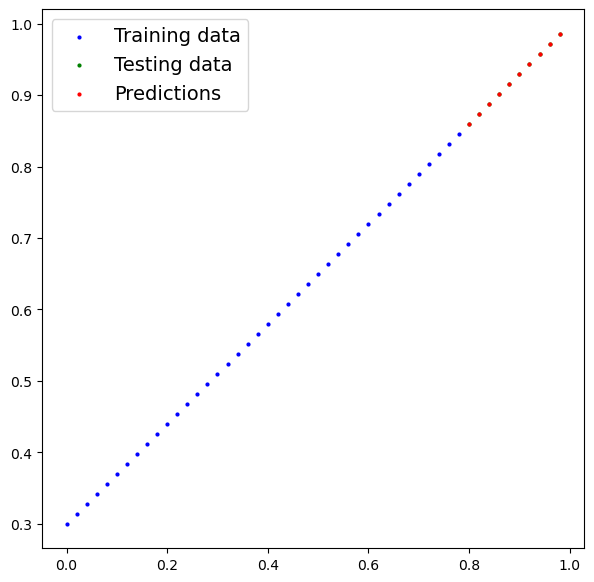

In [36]:
# Visualize
model_1.eval()

with torch.inference_mode():
    data_y_pred_new = model_1(data_X_test)

data_y_pred_new_cpu = data_y_pred_new.cpu()

data_X_train_cpu = data_X_train.cpu()
data_y_train_cpu = data_y_train.cpu()
data_X_test_cpu = data_X_test.cpu()
data_y_test_cpu = data_y_test.cpu()




plot_predictions(train_data=data_X_train_cpu,
                     train_labels=data_y_train_cpu,
                     test_data=data_X_test_cpu,
                     test_labels=data_y_test_cpu,
                     predictions=data_y_pred_new_cpu)



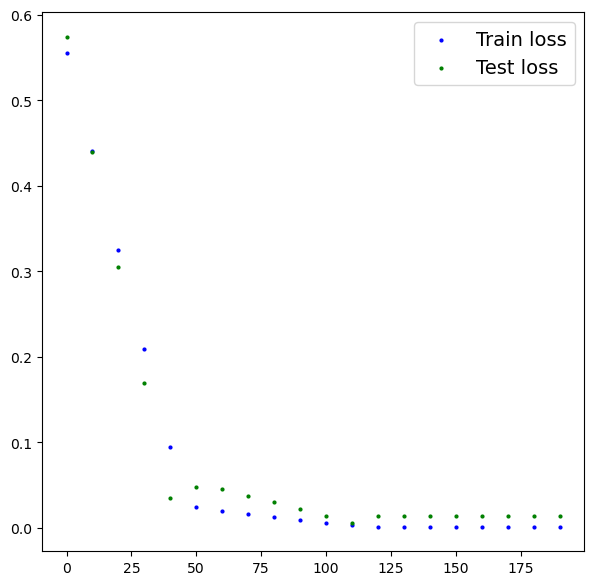

In [37]:
# epoch_count_cpu = epoch_count.cpu()
# loss_values_cpu = loss_values.cpu()
# test_loss_values_cpu = test_loss_values.cpu()
loss_values_cpu = np.array(torch.tensor(loss_values).cpu().numpy())
test_loss_values_cpu = np.array(torch.tensor(test_loss_values).cpu().numpy())

plt.figure(figsize=(7, 7))

plt.scatter(epoch_count, loss_values_cpu, c='b', s=4, label='Train loss')
plt.scatter(epoch_count, test_loss_values_cpu, c='g', s=4, label='Test loss')
plt.legend(prop={'size': 14})

## 6.5 Saving and Loading a trained model `state_dict()`

In [38]:
# 1. Create models directory 
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = '01-workflow-model-1.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
torch.save(obj=model_1.state_dict(),
          f=MODEL_SAVE_PATH)


In [39]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_1 = LinearRegressionModelV2()

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [40]:
# Evaluate loaded model
loaded_model_1.eval()
loaded_model_1.to(device)
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(data_X_test)

In [41]:
data_y_pred_new == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')